In [1]:
import numpy as np
import scipy
import scipy.integrate
from scipy.special import erf
import matplotlib.pyplot as plt
import os

# os.chdir('/Users/kcoppess/muspelheim/quail_volcano/src/')

# import compressible_conduit_steady.steady_state as SS
# import compressible_conduit_steady.material_properties as matprops

# os.chdir('/Users/kcoppess/muspelheim/quail_ODESS_map/')

import steady_state as SS
import material_properties as matprops

In [2]:
Numerics = {
  # Solution order; these correspond to:
  # 0: 1 node in each element representing the average value
  # 1: 2 nodes in each element constituting a linear representation of the
  #    solution in the element
  # 2: 3 nodes in each element constituting a quadratic representation of the
  #    solution in the element
  "SolutionOrder" : 2,
#   "SolutionBasis" : "LagrangeSeg",
#   "Solver" : "DG",
#   "ApplyLimiters" : "PositivityPreservingMultiphasevpT",
#   "ElementQuadrature" : "GaussLegendre",
#   "FaceQuadrature" : "GaussLegendre",
#   # Artificial viscosity adds a diffusion term to all equations, where the                                                                                                                              
#   # strong form residual is large and where the pressure gradient relative to
#   # hydrostatic is large
#   "ArtificialViscosity" : True,
#   "AVParameter" : 0.3,
#   # If L2InitialCondition is false, use interpolation instead of L2 projection of Riemann data
#   'L2InitialCondition': False,
}

Mesh = {
#     "File" : None,
#     "ElementShape" : "Segment",
    # Use even number if using initial condition with discontinuous pressure
    "NumElemsX" : 3000, 
    "xmin" : -3000.0 - 150.0,
    "xmax" : 0.0 - 150.0,
}

In [3]:
n_elems_per_part = Mesh["NumElemsX"]
n_elems_global = 2*n_elems_per_part
if Numerics["SolutionOrder"] == 0:
    n_nodes_global = n_elems_global
elif Numerics["SolutionOrder"] == 1:
    n_nodes_global = n_elems_global + 1
elif Numerics["SolutionOrder"] == 2:
    n_nodes_global = 2*n_elems_global + 1
else:
    raise ValueError("Oops, is there solution order > 2?")
x_global = np.linspace(Mesh["xmin"], Mesh["xmax"], n_nodes_global)

phi_crys = 0.4 * (1.1 - 0.1 * np.cos(0.0)) #0.4025 * (1.1 - 0.1 * np.cos(0.0))
chi_water = 0.05 #0.05055
yWt_init = chi_water * (1 - phi_crys) / (1 + chi_water)
yC_init = phi_crys

p_vent = 1e5          # Vent pressure
inlet_input_val = 3 # Inlet velocity; see also BoundaryCondition["x1"]
input_type = "u"

n0 = chi_water
Sm = 4e-6

props = {
    "yC": yC_init,
    "yWt": yWt_init,
    "yA": 1e-7,
    "yWvInletMin": 1e-5,
    "yCMin": 1e-5,
    "crit_volfrac": 0.7,
    "tau_d": 1.0,
    "tau_f": 1.0,
    "conduit_radius": 50,
    "T_chamber": 1000,
    "c_v_magma": 3e3,
    "rho0_magma": 2.6e3,
    "K_magma": 10e9,
    "p0_magma": (n0 / Sm)**2,
    "solubility_k": Sm,
    "solubility_n": 0.5,
    "neglect_edfm": True,
}

In [5]:
x1 = x_global.copy()
x_quail = np.expand_dims(x1, axis=(1, 2))
p_range = np.linspace(20e6, 100e6, 8)

In [6]:
import steady_state as SS
# Build steady state object
f = SS.SteadyState(x1, p_vent, 175e6, input_type='p', override_properties=props)
# # Retrieve solve_ivp parameters
# f._DEBUG = True
# f.solve_ssIVP(100e6, 2400)
# f.ivp_inputs

Choked at vent.


In [7]:
# Set range of inlet pressures and mass fluxes j0 to try
forward_p = np.linspace(5e5, 250e6, 230//4)
forward_j0 = np.linspace(10, 8000, 200//4)
mg_p, mg_j0 = np.meshgrid(forward_p, forward_j0)
out = SS.parallel_forward_map(f, mg_p, mg_j0, num_processes=12)

In [11]:
''' Choked flow curve sampling (get inlet pressures that are closest to choking
    in samples)'''
# Set filter for row indices that have both subsonic and choked flow
has_choking_filter = np.asarray(~np.all(out["x_top"] >= -150, axis=0) 
         & ~np.all(out["x_top"] < -150, axis=0)).nonzero()[0]
# Get row index of first choked flow given that there is both subsonic + choked
i_choked = np.argmin(out["x_top"] >= -150, axis=0)[has_choking_filter]
# Column index (input mass flux) associated with choked flow
j_choked = np.arange(mg_p.shape[1])[has_choking_filter]

# Extract associated flow values at choking
p_choked = out["p_top"][i_choked, j_choked]
vel_in_choked = out["vel_in"][i_choked, j_choked]
p_in_choked = mg_p[i_choked, j_choked]

''' Approximate exsolution and fragmentation depths '''
mg_depth_exsoln = mg_p.copy()
mg_depth_frag = mg_p.copy()
for i in range(mg_p.ravel().size):
  mg_depth_exsoln.ravel()[i] = np.interp(
    1e-3, out["results"][i][1][2,:], out["results"][i][0])
  # N.B. Below is a proxy, since 50% of total mass includes exsolved water
  mg_depth_frag.ravel()[i] = np.interp(
    0.5, out["results"][i][1][3,:], out["results"][i][0])



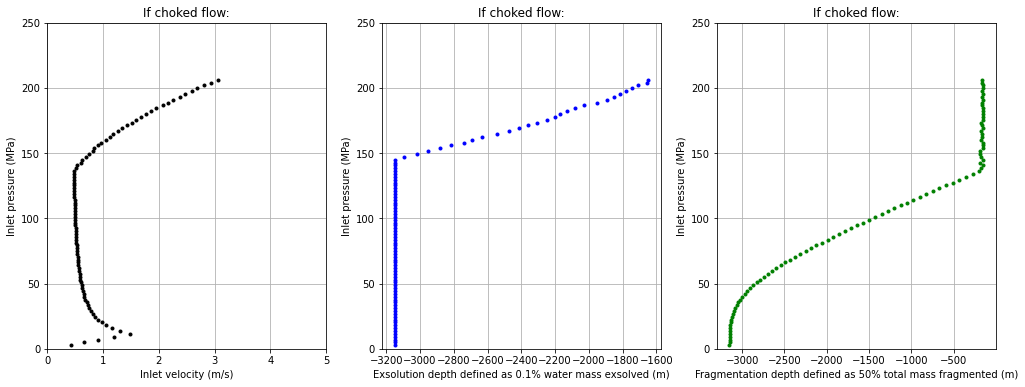

In [80]:
''' Plot p-vel relation at choking'''
plt.figure(figsize=(17,6))
plt.subplot(1,3,1)
plt.plot(vel_in_choked, p_in_choked/1e6, '.k')
plt.xlim(0, 5)
plt.xlabel("Inlet velocity (m/s)")
plt.ylabel("Inlet pressure (MPa)")
# plt.title("Inlet velocity-pressure relation at choked state")

plt.subplot(1,3,2)
plt.plot(mg_depth_exsoln[i_choked, j_choked].ravel(), p_in_choked/1e6, '.b')
plt.xlabel("Exsolution depth defined as 0.1% water mass exsolved (m)")
plt.ylabel("Inlet pressure (MPa)")

plt.subplot(1,3,3)
plt.plot(mg_depth_frag[i_choked, j_choked].ravel(), p_in_choked/1e6, '.g')
plt.ylim(0, 250)
plt.xlabel("Fragmentation depth defined as 50% total mass fragmented (m)")
plt.ylabel("Inlet pressure (MPa)")

# Format
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.grid(axis="both", which="both")
  plt.ylim(0, 250)
  plt.title("If choked flow:")

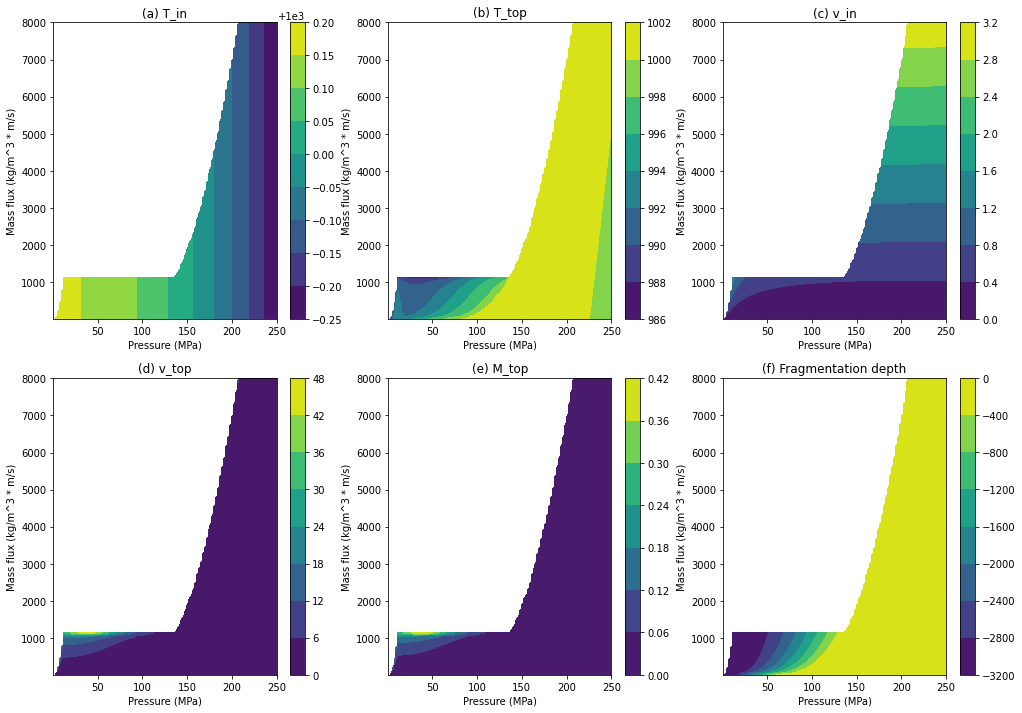

In [84]:
''' Color plots '''

# Define filter for legitimate solutions (solution extends to top)
top_boundary_filter = lambda data: np.where(out["x_top"] >= -150, data, np.nan)

# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.contourf(mg_p/1e6, mg_j0, out["x_top"])
# plt.xlabel("Pressure (MPa)")
# plt.ylabel("Mass flux (...)")
# cb = plt.colorbar(label="x_top")
# plt.subplot(1,2,2)
# plt.contourf(mg_p/1e6, mg_j0, top_boundary_filter(out["p_top"]))
# plt.xlabel("Pressure (MPa)")
# plt.ylabel("Mass flux (...)")
# cb = plt.colorbar(label="p I(x_top == x_target)")
# plt.title("Pressure, legit solutions only")

plt.figure(figsize=(17,12))
plt.subplot(2,3,1)
plt.contourf(mg_p/1e6, mg_j0, top_boundary_filter(out["T_in"]))
plt.title("(a) T_in")
plt.subplot(2,3,2)
plt.contourf(mg_p/1e6, mg_j0, top_boundary_filter(out["T_top"]))
plt.title("(b) T_top")
plt.subplot(2,3,3)
plt.contourf(mg_p/1e6, mg_j0, top_boundary_filter(out["vel_in"]))
# plt.contour(mg_p, mg_j0, out["vel_in"], levels=[0.5, 0.6], colors="red")
plt.title("(c) v_in")
plt.subplot(2,3,4)
plt.contourf(mg_p/1e6, mg_j0, top_boundary_filter(out["vel_top"]))
plt.title("(d) v_top")
plt.subplot(2,3,5)
plt.contourf(mg_p/1e6, mg_j0, top_boundary_filter(out["M_top"]))
plt.title("(e) M_top")
plt.subplot(2,3,6)
plt.contourf(mg_p/1e6, mg_j0, top_boundary_filter(mg_depth_frag))
plt.title("(f) Fragmentation depth")

for i in range(1,7):
  plt.subplot(2,3,i)
  plt.xlabel("Pressure (MPa)")
  plt.ylabel("Mass flux (kg/m^3 * m/s)")
  plt.colorbar()

## Older stuff

In [ ]:
# [plt.semilogy(x1, _f(x1, io_format="phy")[0]) for _f in solvep]

In [7]:


f1 = SS.SteadyState(x1, p_vent, 75e6, input_type='p', override_properties=props)
f5 = SS.SteadyState(x1, p_vent, 90e6, input_type='p', override_properties=props)

soln1 = f1(x1, io_format="phy")
p1, h1, y1, yFsoln1 = soln1[0:4]
T1 = f1.T_ph(p1, h1, y1)
rho1 = 1.0 / f1.v_mix(p1, T1, y1)

soln_quail1 = f1(x_quail, io_format="quail")
u1 = f1.j0 / rho1
c_fn1 = lambda p, h, yWv: f1.mixture.sound_speed(
  p, f1.T_ph(p, h, yWv), f1.yA, yWv, 1.0 - f1.yA - yWv)
c1 = np.array(list(map(c_fn1, p1, h1, y1)))
phi1 = f1.mixture.vf_g(p1, T1, f1.yA, y1, 1.0-f1.yA-y1)

drag_fn1 = lambda p1, T1, y1, yFsoln1, rho1, u1: f1.F_fric(p1, T1, y1, yFsoln1, rho1, u1)
drag1 = np.array(list(map(drag_fn1, p1, T1, y1, yFsoln1, rho1, u1)))
eta_fn1 = lambda T1, y1, yFsoln1: f1.F_fric_viscosity_model(T1, y1, yFsoln1)
eta1 = np.array(list(map(eta_fn1, T1, y1, yFsoln1)))

soln5 = f5(x1, io_format="phy")
p5, h5, y5, yFsoln5 = soln5[0:4]
T5 = f5.T_ph(p5, h5, y5)
rho5 = 1.0 / f5.v_mix(p5, T5, y5)
soln_quail5 = f5(x_quail, io_format="quail")
u5 = f5.j0 / rho5
c_fn5 = lambda p, h, yWv: f5.mixture.sound_speed(
  p, f5.T_ph(p, h, yWv), f5.yA, yWv, 1.0 - f5.yA - yWv)
c5 = np.array(list(map(c_fn5, p5, h5, y5)))
phi5 = f5.mixture.vf_g(p5, T5, f5.yA, y5, 1.0-f5.yA-y5)
drag_fn5 = lambda p1, T1, y1, yFsoln1, rho1, u1: f5.F_fric(p1, T1, y1, yFsoln1, rho1, u1)
drag5 = np.array(list(map(drag_fn5, p5, T5, y5, yFsoln5, rho5, u5)))
eta_fn5 = lambda T1, y1, yFsoln1: f5.F_fric_viscosity_model(T1, y1, yFsoln1)
eta5 = np.array(list(map(eta_fn5, T5, y5, yFsoln5)))

Choked at vent.


c:\Users\Fredric\Documents\Volcano\quail_volcano\src\compressible_conduit_steady\material_properties.py:168: RuntimeWarning: invalid value encountered in log
  return self.K/self.rho0 * (u - np.log(1 + u))


Choked at vent.


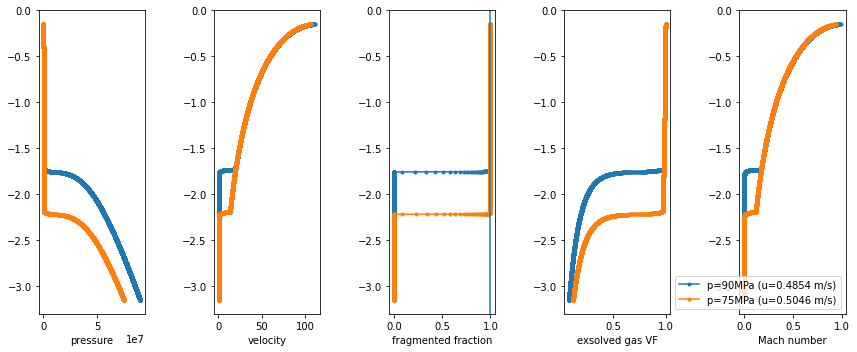

In [8]:
%matplotlib inline

x = x_global.copy()

plt.figure(figsize=(12,5))
plt.subplot(1,5,1)
plt.plot(p5, x*1e-3, '.-')
plt.plot(p1, x*1e-3, '.-')
# plt.plot(eta1 * (1 - yFsoln1 / (1.0 - y1)), x*1e-3, '.-')
# plt.plot(eta1, x*1e-3, '.-')
plt.xlabel('pressure')
plt.subplot(1,5,2)
plt.plot(u5, x*1e-3, '.-')
plt.plot(u1, x*1e-3, '.-')
plt.xlabel('velocity')
plt.subplot(1,5,3)
plt.plot(yFsoln5 / (1.0 - y5), x*1e-3, '.-')
plt.plot(yFsoln1/ (1.0 - y1), x*1e-3, '.-')
plt.axvline(1)
plt.xlabel('fragmented fraction')
plt.subplot(1,5,4)
plt.plot(phi5, x*1e-3, '.-')
plt.plot(phi1, x*1e-3, '.-')
plt.xlabel('exsolved gas VF')
plt.subplot(1,5,5)
plt.plot(u5/c5, x*1e-3, '.-', label=f'p={p5.ravel()[0]/1e6:.0f}MPa (u={u5.ravel()[0]:.4f} m/s)')
plt.plot(u1/c1, x*1e-3, '.-', label=f'p={p1.ravel()[0]/1e6:.0f}MPa (u={u1.ravel()[0]:.4f} m/s)')
plt.xlabel('Mach number')
plt.legend(loc=4)

plt.tight_layout()
# plt.savefig('/Users/kcoppess/Desktop/steadystate/exampleSoln1.png', dpi=300)
plt.show() 